# Continuous Control

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the second project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [ ]:
env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [1]:
import copy
import torch
import random
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
from unityagents import UnityEnvironment
from collections import namedtuple, deque

env = UnityEnvironment(file_name='Reacher_Windows_x86_64/Reacher.exe')

brain_name = env.brain_names[0]
brain = env.brains[brain_name]
env_info = env.reset(train_mode=True)[brain_name]
action_size = brain.vector_action_space_size
state_size = env_info.vector_observations.shape[1]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


### Actor and Critic Architectures

In [10]:
def weight_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)

class Actor(nn.Module):
    def __init__(self, state_size, action_size, hu=(512, 256)):
        super(Actor, self).__init__()
        
        self.input_layer = nn.Linear(state_size, hu[0])
        self.hl1 = nn.Linear(hu[0], hu[1])
        #self.hl2 = nn.Linear(hu[1], hu[2])
        #self.bn1 = nn.BatchNorm1d(num_features=hu[1])
        self.output_layer = nn.Linear(hu[1], action_size)
        self.reset_parameters()
        
    def reset_parameters(self):
        self.input_layer.weight.data.uniform_(*weight_init(self.input_layer))
        self.hl1.weight.data.uniform_(*weight_init(self.hl1))
        #self.hl2.weight.data.uniform_(*weight_init(self.hl2))
        self.output_layer.weight.data.uniform_(-3e-3, 3e-3)
        
    def forward(self, state):
        x = F.relu(self.input_layer(state))
        x = F.relu(self.hl1(x))
        #x = F.relu(self.hl2(x))
        return F.tanh(self.output_layer(x))
    
class Critic(nn.Module):
    def __init__(self, state_size, action_size, hu=(512, 256)):
        super(Critic, self).__init__()
        
        self.input_layer = nn.Linear(state_size, hu[0])
        self.hl1 = nn.Linear(hu[0]+action_size, hu[1])
        #self.hl2 = nn.Linear(hu[1], hu[2])
        #self.bn1 = nn.BatchNorm1d(num_features=hu[1])
        self.output_layer = nn.Linear(hu[1], 1)
        self.reset_parameters()
        
    def reset_parameters(self):
        self.input_layer.weight.data.uniform_(*weight_init(self.input_layer))
        self.hl1.weight.data.uniform_(*weight_init(self.hl1))
        #self.hl2.weight.data.uniform_(*weight_init(self.hl2))
        self.output_layer.weight.data.uniform_(-3e-3, 3e-3)
        
    def forward(self, state, action):
        x = F.relu(self.input_layer(state))
        x = torch.cat((x, action), dim=1)
        x = F.relu(self.hl1(x))
        #x = F.relu(self.hl2(x))
        return self.output_layer(x)

### Default hyperparameters

In [31]:
BUFFER_SIZE = int(3e6)  # replay buffer size
BATCH_SIZE = 1024        # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR_ACTOR = 1e-4         # learning rate of the actor 
LR_CRITIC = 2e-4        # learning rate of the critic
WEIGHT_DECAY = 0.      # L2 weight decay
update_every = 20

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [26]:
class Agent():
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        
        ### Actor online and target networks
        self.actor_online = Actor(state_size, action_size).to(device)
        self.actor_target = Actor(state_size, action_size).to(device)
        self.actor_optimizer = optim.Adam(self.actor_online.parameters(), lr=LR_ACTOR)
        
        ### Critic online and target networks
        self.critic_online = Critic(state_size, action_size).to(device)
        self.critic_target = Critic(state_size, action_size).to(device)
        self.critic_optimizer = optim.Adam(self.critic_online.parameters(), lr=LR_CRITIC, weight_decay = WEIGHT_DECAY)
        
        
        ### Noise generator for exploration
        self.noise = OUnoise(action_size)
        
        ### Replay buffer
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE)
        
        self.tstep = 0
        
    def step(self, state, action, reward, next_state, done, cycles=3):
        # Commit experience to memory
        self.memory.add(state, action, reward, next_state, done)
        
        self.tstep = (self.tstep +1)%update_every
        
        # Optimise
        c=0
        if (self.tstep==0):
            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample()
                while c < cycles:
                    self.learn(experiences, GAMMA)
                    c+=1
            
    def act(self, state, add_noise=True):
        state = torch.from_numpy(state).float().to(device)
        self.actor_online.eval()
        with torch.no_grad():
            action = self.actor_online(state).cpu().data.numpy()
        self.actor_online.train()
        if add_noise:
            action += self.noise.sample()
        return np.clip(action, -1, 1)
    
    def reset(self):
        self.noise.reset()
        
    def learn(self, experiences, gamma):
        states, actions, rewards, next_states, dones = experiences
        
        ### Update critic
        actions_next = self.actor_target(next_states)
        Q_targets_next = self.critic_target(next_states, actions_next)
        Q_targets = rewards + (gamma * Q_targets_next * (1-dones))
        Q_expected = self.critic_online(states, actions)
        critic_loss = F.mse_loss(Q_expected, Q_targets)
        
        # Backprop
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        torch.nn.utils.clip_grad_norm(self.critic_online.parameters(), 1)
        self.critic_optimizer.step()
        
        
        ### Update actor
        actions_pred = self.actor_online(states)
        actor_loss = -self.critic_online(states, actions_pred).mean()
        
        # Backprop
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()
        
        
        ### Update targets
        self.soft_update(self.critic_online, self.critic_target, TAU)
        self.soft_update(self.actor_online, self.actor_target, TAU)
        
    def soft_update(self, online_model, target_model, tau):
        for target_param, online_param in zip(target_model.parameters(), online_model.parameters()):
            target_param.data.copy_(tau*online_param.data + (1.0-tau)*target_param.data)
            
            
class OUnoise:
    def __init__(self, size, mu=0., theta=0.15, sigma=0.2):
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.reset()
        
    def reset(self):
        self.state = copy.copy(self.mu)
        
    def sample(self):
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.standard_normal(len(x))
        self.state = x + dx
        return self.state
    

class ReplayBuffer:
    def __init__(self, action_size, buffer_size, batch_size):
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])

    def add(self, state, action, reward, next_state, done):
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def sample(self):
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
        
        return (states, actions, rewards, next_states, dones)
    
    def __len__(self):
        return len(self.memory)

In [34]:
agent = Agent(state_size, action_size)

In [35]:
def ddpg(n_episodes=1000, max_t=1000):
    scores_deque = deque(maxlen=100)
    scores = []
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]           # reset the environment 
        state = env_info.vector_observations[0]                     # get the current state
        agent.reset()                                               # reset the agent
        score = 0                                                   # initialize the score
        for t in range(max_t):
            action = agent.act(state)
            env_info = env.step(action)[brain_name]                 # send action to tne environment
            next_state = env_info.vector_observations[0]            # get next state
            reward = env_info.rewards[0]                            # get reward
            done = env_info.local_done[0]                           # see if episode finished
            agent.step(state, action, reward, next_state, done)     # agent takes one step to train
            state = next_state                                      # roll over state to next time step
            score += reward                                         # update the score
            if done:                                                # exit loop if episode finished
                break 
        scores_deque.append(score)
        scores.append(score)
        print('\rEpisode {}\tAverage Score: {:.2f}\tScore: {:.2f}'.format(i_episode, np.mean(scores_deque), score), end="")
        if np.mean(scores_deque)>=30.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_deque)))
            torch.save(agent.actor_online.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_online.state_dict(), 'checkpoint_critic.pth')
            break
            
    return scores

scores = ddpg()

Episode 1	Average Score: 0.00	Score: 0.00

C:\Users\Andre\Anaconda3\envs\drlnd\lib\site-packages\ipykernel_launcher.py:66: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.


Episode 1000	Average Score: 27.03	Score: 26.23

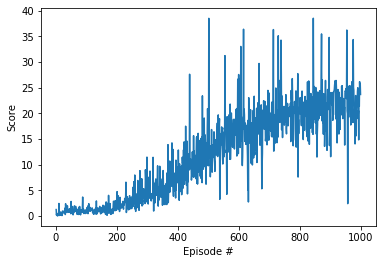

In [29]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [36]:
env.close()

In [ ]:
random.normalvariate(0,1)

In [ ]:
env_info.vector_observations[0]